In [ ]:
# EpiBERT caqTL Prediction Example
# This notebook demonstrates how to use EpiBERT to predict chromatin accessibility
# quantitative trait loci (caqTL) effects - i.e., how genetic variants affect
# chromatin accessibility.

import sys
import os
import warnings
from pathlib import Path

# Add parent directory to path for imports
notebook_dir = Path(os.getcwd())
sys.path.append(str(notebook_dir.parent))

# Suppress TensorFlow warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning, module='tensorflow_addons')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Core imports
import tensorflow as tf
import tensorflow.experimental.numpy as tnp
from tensorflow import strings as tfs
from tensorflow.keras import mixed_precision

# EpiBERT imports (using refactored modules)
import src.models.epibert_atac_pretrain as epibert
import training_utils_atac_pretrain as training_utils
import analysis.interval_and_plotting_utilities as utils

# Additional utilities
from scipy import stats
import kipoiseq

# Configure GPU memory growth to prevent OOM errors on re-runs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f"GPU memory growth setup failed: {e}")

# Use mixed precision for better performance
mixed_precision.set_global_policy('mixed_bfloat16')

print("✓ Imports completed successfully")
print(f"✓ TensorFlow version: {tf.__version__}")
print(f"✓ GPU available: {tf.config.list_physical_devices('GPU')}")
print(f"✓ Mixed precision policy: {mixed_precision.global_policy().name}")

In [ ]:
# Configuration - Update these paths for your environment
# =======================================================

# Path to reference genome FASTA file (hg38)
# Download from: https://www.encodeproject.org/references/ENCSR938RZZ/
fasta_file = 'hg38_erccpatch.fa'

# Path to GTF file for gene annotations
gtf_file = '/home/jupyter/data/hg38.refGene.gtf'

# Paths to trained EpiBERT model checkpoints
# These should be two different models trained on different data splits
checkpoint1_path = "/home/jupyter/models/model1/ckpt-45"
checkpoint2_path = "/home/jupyter/models/model2/ckpt-45"

# Example ATAC-seq data file (processed bedgraph format)
atac_file = "/home/jupyter/EpiBERT/example_usage/K562.adjust.bed.gz"

# Motif enrichment file (generated using MEME SEA tool)
motif_activity = '/home/jupyter/EpiBERT/example_usage/ENCFF135AEX.motifs.tsv'

print("✓ Configuration set")

# Initialize FASTA extractor
# =========================
fasta_extractor = utils.FastaStringExtractor(fasta_file)
print(f"✓ FASTA extractor initialized with {fasta_file}")

# Load EpiBERT models
# ==================
print("Loading EpiBERT models...")
model1 = epibert.epibert()
model2 = epibert.epibert()

# Create ensemble model wrapper
epibert_model = utils.EpiBERT_model_nostrat(model1, model2, checkpoint1_path, checkpoint2_path)
print("✓ EpiBERT models loaded successfully")

Loaded checkpoints.


In [ ]:
# Single Variant Scoring Example
# ===============================

# Define a test variant: C -> T transition at chr12:9764948 (CD69 enhancer region)
# Format: (genomic_position, alternate_allele)
variant = ('chr12:9764948', 'T')

print(f"Analyzing variant: {variant[0]} -> {variant[1]}")
print("This variant is located in a CD69 enhancer region")

In [ ]:
# Prepare inputs for variant scoring
# ===================================
print("Preparing inputs for variant analysis...")

# Extract genomic sequence and prepare model inputs
# This function handles:
# - Extracting reference and alternate sequences
# - Processing ATAC-seq data for the region
# - Preparing motif enrichment features
# - Creating proper input tensors for the model
inputs, inputs_mut, masked_atac, motif, target_atac, masked_atac_reshape, mask, mask_centered, interval_resize = \
    utils.return_inputs_caqtl_score(variant, atac_file, motif_activity, fasta_extractor)

print(f"✓ Inputs prepared for region: {interval_resize}")
print(f"✓ Input sequence shape: {inputs[0].shape}")
print(f"✓ ATAC-seq data shape: {masked_atac.shape}")
print(f"✓ Motif features shape: {motif.shape}")

In [ ]:
# Run variant effect prediction
# ==============================
print("Running EpiBERT prediction...")

# Use GPU if available, otherwise CPU
device = '/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'
print(f"Using device: {device}")

with tf.device(device):
    # Get predictions for both reference and alternate sequences
    # Returns: wild-type prediction, mutant prediction, and caqTL score
    output, output_mut, caqtl_score = epibert_model.ca_qtl_score(inputs, inputs_mut)

print(f"✓ Prediction completed")
print(f"✓ Wild-type prediction shape: {output.shape}")
print(f"✓ Mutant prediction shape: {output_mut.shape}")
print(f"✓ caqTL score: {caqtl_score:.2f}")

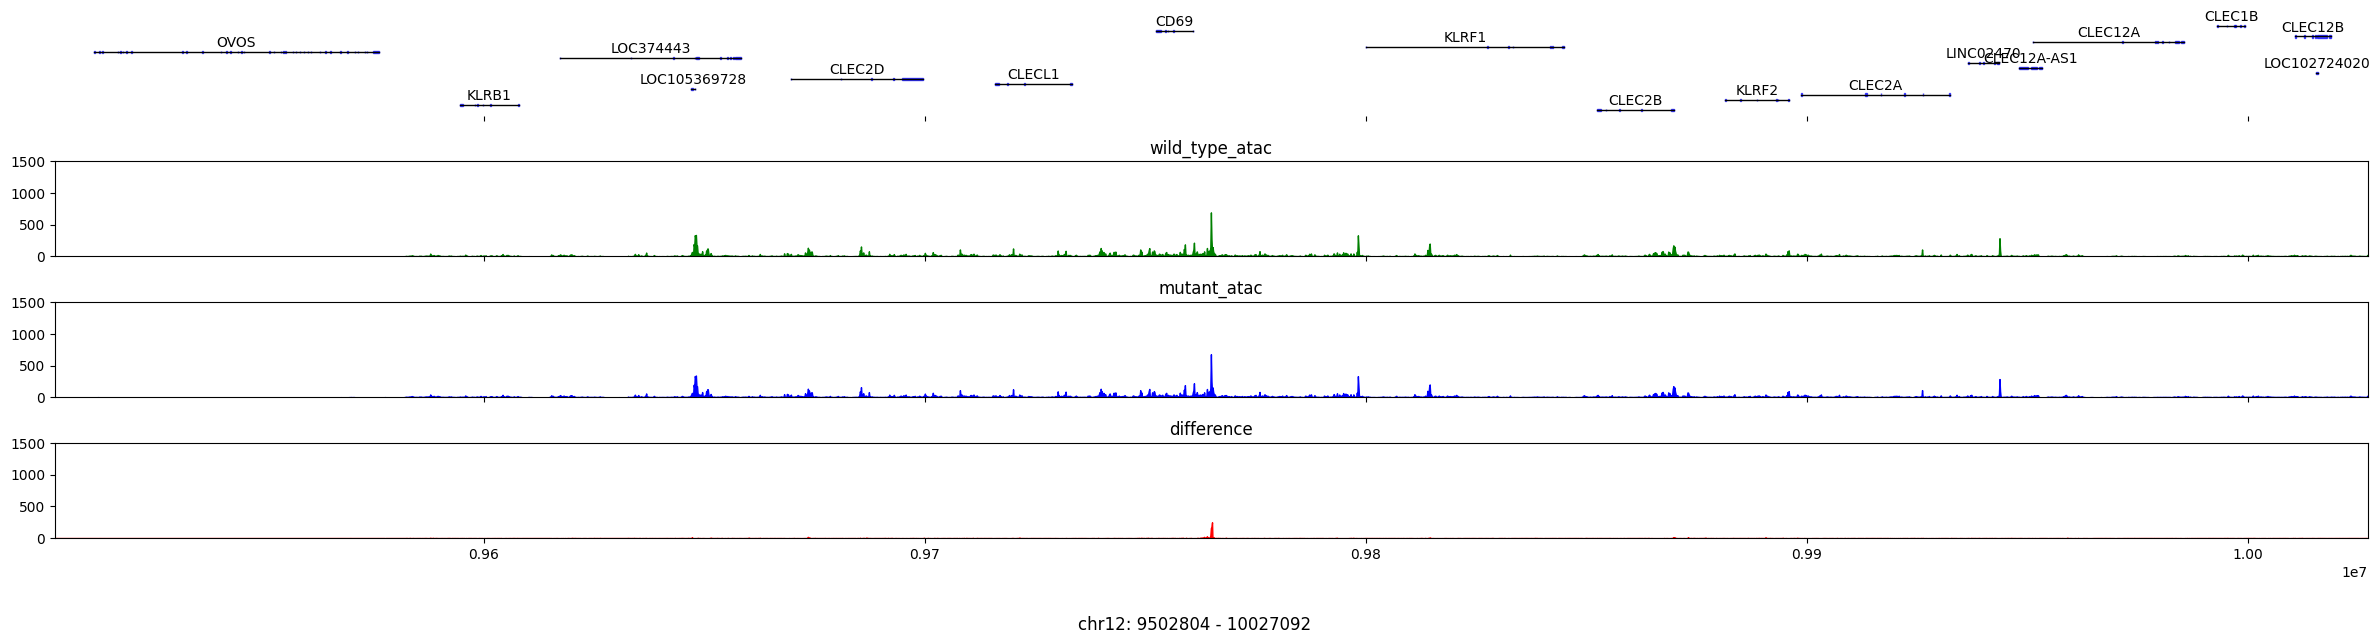

In [ ]:
# Visualize predictions across the genomic region
# ===============================================
print("Creating visualization of predictions...")

# Prepare tracks for plotting
# - Wild-type: predicted accessibility for reference sequence
# - Mutant: predicted accessibility for alternate sequence  
# - Difference: effect of the variant (amplified 10x for visibility)
tracks = {
    'wild_type_atac': (output, 'green'),
    'mutant_atac': (output_mut, 'blue'),
    'difference': ((output - output_mut) * 10, 'red')
}

# Plot tracks with gene annotations
# The plot shows the entire genomic region analyzed by EpiBERT
utils.plot_tracks_with_genes(tracks, gtf_file, interval_resize, 1500)
print("✓ Full region plot generated") 

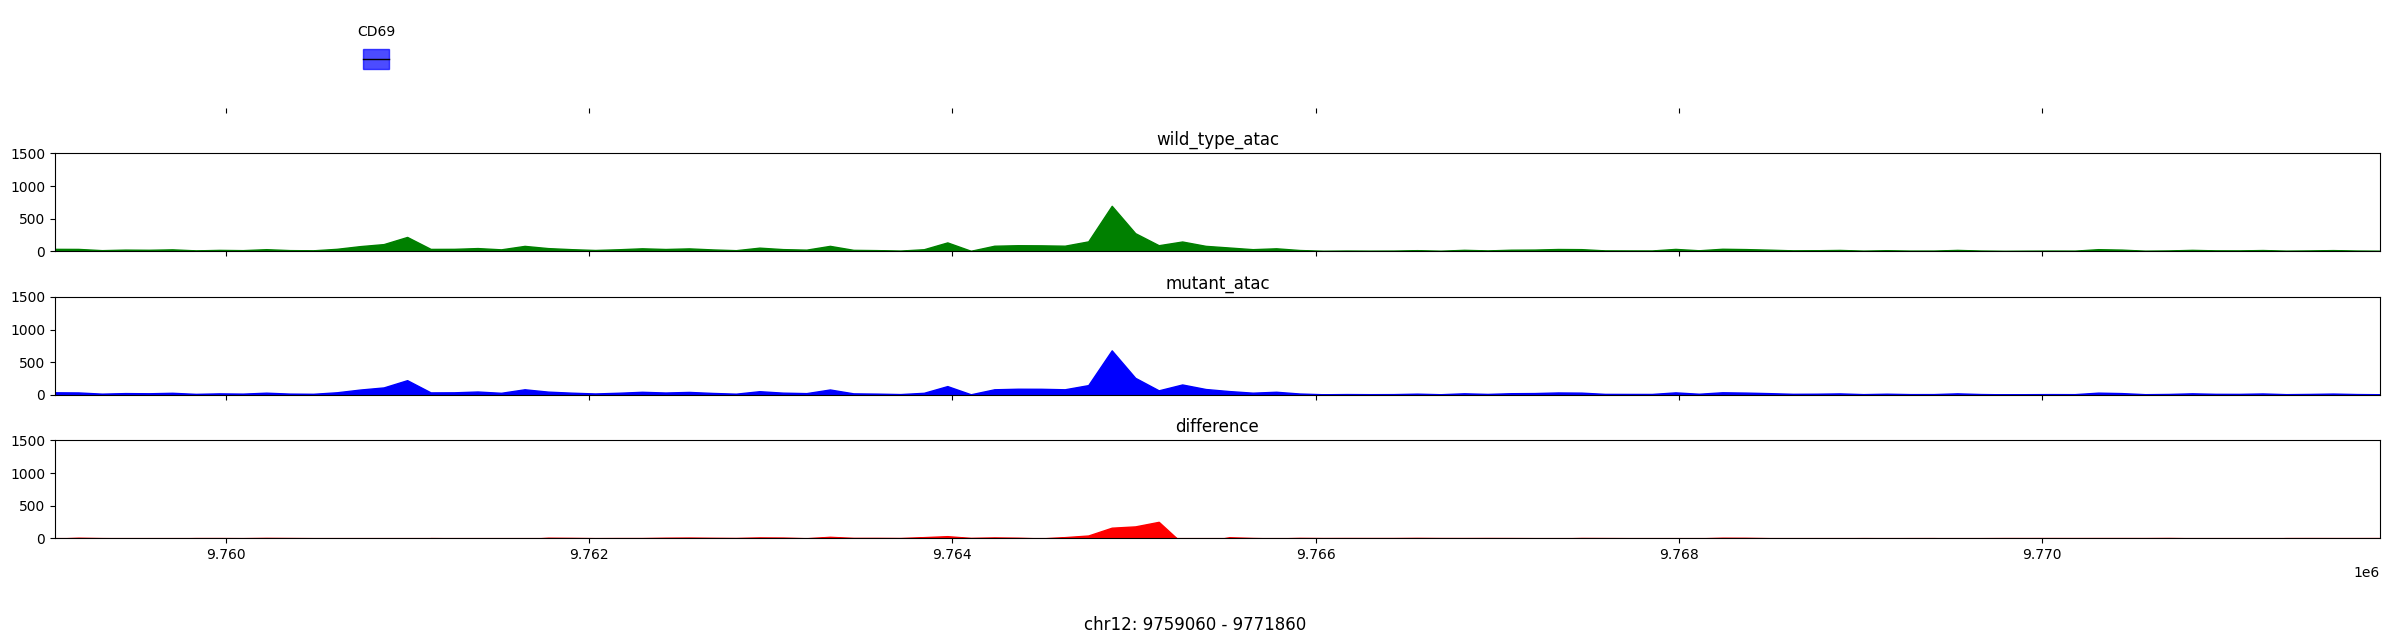

In [ ]:
# Zoom in to the variant location
# ================================
print("Creating zoomed view around variant...")

# Focus on a 100bp window around the variant (center of the prediction window)
# The variant is at the center of the 4096bp input, so positions 2000-2100 
# correspond to the immediate vicinity of the variant
zoom_start, zoom_end = 2000, 2100
tracks_zoomed = {
    'wild_type_atac': (output[zoom_start:zoom_end], 'green'),
    'mutant_atac': (output_mut[zoom_start:zoom_end], 'blue'),
    'difference': ((output - output_mut)[zoom_start:zoom_end] * 10, 'red')
}

# Calculate the genomic coordinates for the zoomed region
# Each prediction position corresponds to 128bp in the genome
zoomed_interval = (
    interval_resize[0], 
    interval_resize[1] + 128 * (2 + zoom_start), 
    interval_resize[1] + 128 * (2 + zoom_end)
)

utils.plot_tracks_with_genes(tracks_zoomed, gtf_file, zoomed_interval, 1500)
print(f"✓ Zoomed plot generated for region: {zoomed_interval[1]}-{zoomed_interval[2]}") 

In [ ]:
# Display the caqTL score
# =======================
print(f"caqTL Score: {caqtl_score:.2f}")
print("\nInterpretation:")
print("- Positive scores indicate increased accessibility")
print("- Negative scores indicate decreased accessibility") 
print("- Larger absolute values indicate stronger effects")
print(f"- This variant shows a {'gain' if caqtl_score > 0 else 'loss'} of accessibility")

-8.0


In [ ]:
# Batch Variant Scoring Example
# ==============================
print("Analyzing multiple variants...")

# Define a list of variants to test
# Testing different alleles at the same position and nearby positions
variant_list = [
    ('chr12:9764948', 'T'),  # Original variant
    ('chr12:9764948', 'G'),  # Different allele at same position
    ('chr12:9764948', 'A'),  # Another allele at same position
    ('chr12:9764958', 'C'),  # Nearby variant (+10bp)
    ('chr12:9764949', 'T'),  # Adjacent variant (+1bp)
    ('chr12:9764100', 'T'),  # Distant variant in same region
]

print(f"Testing {len(variant_list)} variants...")

# Score each variant
variant_scores = {}
with tf.device(device):
    for i, variant in enumerate(variant_list, 1):
        print(f"  Processing variant {i}/{len(variant_list)}: {variant[0]} -> {variant[1]}")
        
        # Prepare inputs for this variant
        inputs, inputs_mut, masked_atac, motif, target_atac, masked_atac_reshape, mask, mask_centered, interval_resize = \
            utils.return_inputs_caqtl_score(variant, atac_file, motif_activity, fasta_extractor)
        
        # Get prediction
        output, output_mut, caqtl_score = epibert_model.ca_qtl_score(inputs, inputs_mut)
        variant_scores[variant] = caqtl_score

print("✓ Batch scoring completed")

In [ ]:
# Display results in a formatted table
# ====================================
import pandas as pd

# Convert results to a more readable format
results_data = []
for variant, score in variant_scores.items():
    position, alt_allele = variant
    results_data.append({
        'Position': position,
        'Alt_Allele': alt_allele,
        'caqTL_Score': round(score, 3),
        'Effect': 'Gain' if score > 0 else 'Loss',
        'Magnitude': 'Strong' if abs(score) > 5 else 'Moderate' if abs(score) > 2 else 'Weak'
    })

# Create and display results table
results_df = pd.DataFrame(results_data)
results_df = results_df.sort_values('caqTL_Score', key=abs, ascending=False)

print("Variant Effect Summary:")
print("=" * 60)
print(results_df.to_string(index=False))

print(f"\nTop effect: {results_df.iloc[0]['Position']} -> {results_df.iloc[0]['Alt_Allele']} (score: {results_df.iloc[0]['caqTL_Score']})")

# Also show the raw dictionary for reference
print("\nRaw scores dictionary:")
variant_scores

{('chr12:9764948', 'T'): -72.0,
 ('chr12:9764948', 'G'): 0.0,
 ('chr12:9764948', 'A'): -48.0,
 ('chr12:9764958', 'C'): 0.0,
 ('chr12:9764949', 'T'): -4.0,
 ('chr12:9764100', 'T'): -0.5}

In [ ]:
## Summary

This notebook demonstrates how to use EpiBERT for chromatin accessibility QTL (caqTL) prediction. The workflow includes:

1. **Setup**: Loading models, configuring paths, and preparing data extractors
2. **Single variant analysis**: Predicting the effect of a specific genetic variant
3. **Visualization**: Plotting predicted accessibility changes across the genomic region
4. **Batch analysis**: Scoring multiple variants efficiently

### Key Points:

- **caqTL scores** represent the predicted change in chromatin accessibility due to a genetic variant
- **Positive scores** indicate increased accessibility (potential gain-of-function)
- **Negative scores** indicate decreased accessibility (potential loss-of-function)
- **Larger absolute values** indicate stronger predicted effects

### Next Steps:

- Analyze your own variants by updating the `variant_list` 
- Experiment with different genomic regions and cell types
- Compare predictions with experimental caqTL data for validation
- Use the batch scoring approach for genome-wide variant effect prediction

### Requirements:

- Trained EpiBERT model checkpoints
- Reference genome FASTA file (hg38)
- ATAC-seq data in processed bedgraph format
- Motif enrichment file from MEME SEA analysis
- Gene annotation GTF file for visualization
